# <span style="color:red"> Laboratorio di Simulazione Numerica (LSN) </span>

#### Luca Camillini - Luglio 2021

## <span style="color:blue">  Esercitazione 7</span>

In questa esercitazione vogliamo simulare lo stesso sistema di molecole di Argon in una scatola nelle tre fasi (solida, liquida e gassosa) che avevamo nell'esercitazione 4. Tuttavia, questa volta, invece che usare algoritmi che simulano la dinamica del sistema, L'evoluzione avviene tramite l'algoritmo di Metropolis: una mossa consiste nel muovere ogni molecola di un certo step fissato, in direzione casuale, e accettare o rigettare la mossa secondo una certa probabilità.

### Esercizio 07.1
Nell'esercitazione 4 il calcolo del potenziale avveniva considerando solo le molecole interne a un certo raggio di *cut-off*. Ora vogliamo aggiungere un termine correttivo (*correzioni di coda*) per non trascurare completamente i contributi dati all'energia potenziale e alla pressione da quelle molecole più lontane. 

#### Stima delle correzioni di coda
Per stimare la correzione consideriamo, innanzitutto, la funzione di distribuzione radiale $g(r)$. Essa esprime la densità di coppie di particelle poste a distanza $r$. Per un sistema omogeneo assumiamo che $g(r)\simeq 1$. In questo il contributo di coda all'energia potenziale è
$$
\langle V \rangle_{tail} = 2\pi \rho N \int_{r_{c}}^{\infty}r^{2}v(r)g(r)\,dr = 2\pi \rho N \int_{r_{c}}^{\infty}r^{2}v(r)\,dr
$$

da cui segue che 
$$
\frac{\langle V_{LJ} \rangle_{tail}}{N} \simeq \frac{8\pi \rho_{LJ}\epsilon}{9r_{c(LJ)}^{9}} - \frac{8\pi \rho_{LJ}\epsilon}{3r_{c(LJ)}^{3}} 
$$

Con un procedimento analogo si ricava la correzione per pressione:

$$
\frac{\langle w_{LJ} \rangle_{tail}}{3N\epsilon} \simeq 32\pi \rho_{LJ}\left[ \frac{1}{9r_{c(LJ)}^{9}} - \frac{1}{6r_{c(LJ)}^{3}} \right] 
$$

I contributi vengono sommati alle rispettive grandezze fisiche.

### Esercizio 07.2

In questo esercizio misuriamo l'energia potenziale per particella $U/N$ per un sistema precedentemente equilibrato, ad ogni step Monte Carlo, per un totale di $5\times 10^5$ steps impostando adeguatamente il $\Delta r$ compiuto dalle singole molecole. Il rate di accettazione viene mantenuto sempre al $50\%$. Tale procedura viene eseguita per le tre fasi della materia:
- solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cut-off: $r_c = 2.2$)
- liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cut-off: $r_c = 2.5$)
- gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off: $r_c = 5.0$)

Prodotti questi dati andiamo a vedere:
1. la funzione di correlazione temporale per determinare quanti passi sono necessari per avere misure scorrelate: ciò permette la scelta più corretta della dimensione dei blocchi per la procedura di data blocking
2. l'ampiezza dell'incertezza statistica in funzione della dimensione del blocco. Anche questa procedura ha come scopo quello di determinare la dimenisione più corretta dei blocchi.

#### Funzione di autocorrelazione
Definiamo la funzione di autocorrelazione nel seguente modo:
$$Ac(\tau) = \frac{cov(x(t)x(t+\tau))}{cov(x(t)x(t))}$$
Per calcolarla sfrutteremo le librerie di *Pandas*.

### Fase SOLIDA

#### Equilibrazione, autocorrelazione e incertezza statistica

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import Series
import math
from tqdm import tqdm

%config InlineBackend.figure_format='retina'

def blk_err(x,L):
    n_blk = (int)(x.size/L)
    blk_ave = np.zeros(n_blk)
    for i in range(n_blk):
        blk_ave[i] = np.sum(x[i*L:(i+1)*L])/L
    return math.sqrt(abs(np.sum(blk_ave*blk_ave)/n_blk - (np.sum(blk_ave)/n_blk)**2)/(n_blk-1))

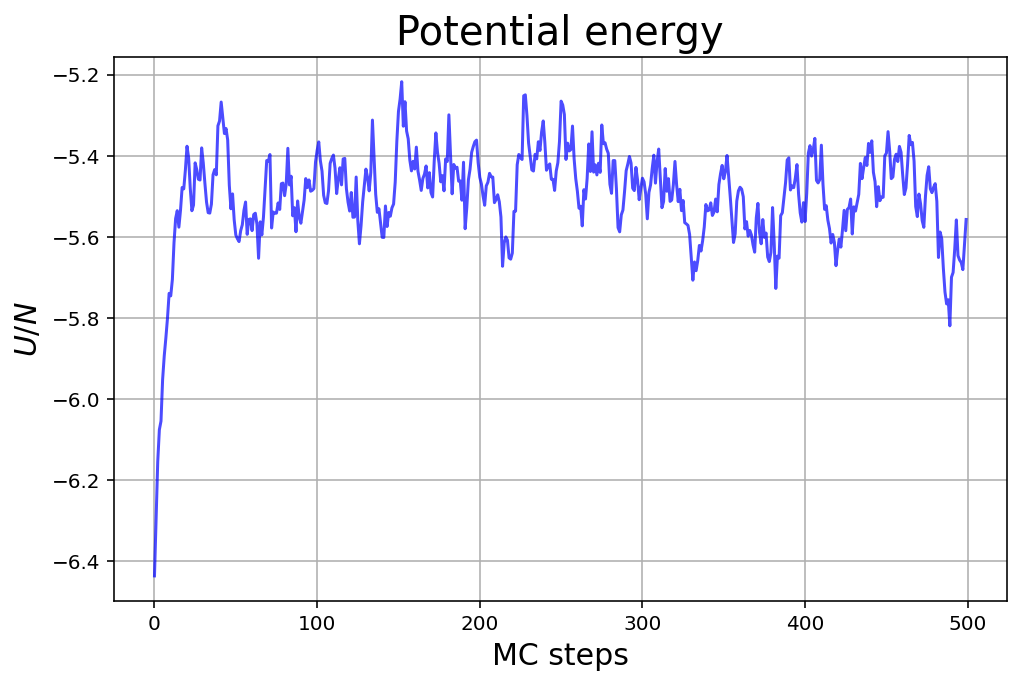

In [2]:
blk, eq_solid = np.loadtxt('MDNVE_MCNVT/01_Solid/MC_equilibration.dat', usecols=(0,1), unpack='true')

fig, ax = plt.subplots(figsize=(8,5))
ax.errorbar(blk[0:500], eq_solid[0:500], color='b', alpha=0.7)
ax.set_title('Potential energy', size=20)
ax.set_xlabel('MC steps', size=15)
ax.set_ylabel('$U/N$', size=15)
ax.grid()

100%|██████████| 5000/5000 [00:01<00:00, 3763.55it/s]


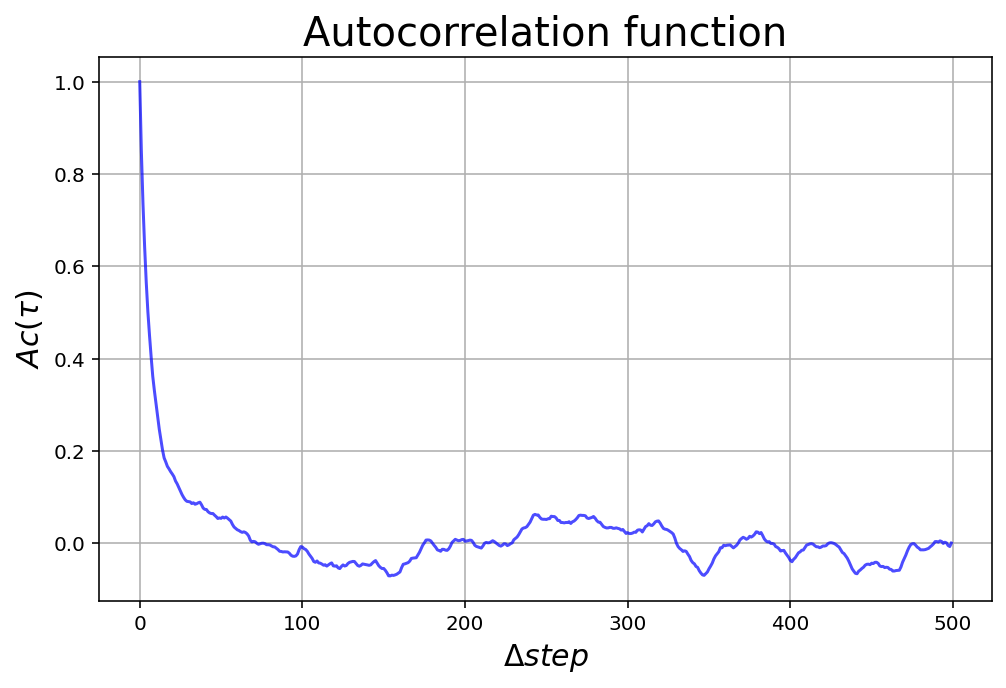

In [3]:
x_solid = np.loadtxt('MDNVE_MCNVT/01_Solid/MC_autocorr.dat', usecols=1, unpack='true')
auto_corr = np.zeros(int(x_solid.size/2))
a = pd.Series(x_solid)

for i in tqdm(range(int(x_solid.size/2))):
    y = np.roll(x_solid,i)
    y = pd.Series(y)
    auto_corr[i] = pd.Series.cov(a,y)/pd.Series.cov(a,a)

fig, ax = plt.subplots(figsize=(8,5))

ax.plot(auto_corr[0:500], color='b', alpha=0.7)
ax.set_title('Autocorrelation function', size=20)
ax.set_xlabel(r'$\Delta step$', size=15)
ax.set_ylabel(r'$Ac(\tau)$', size=15)
ax.grid()

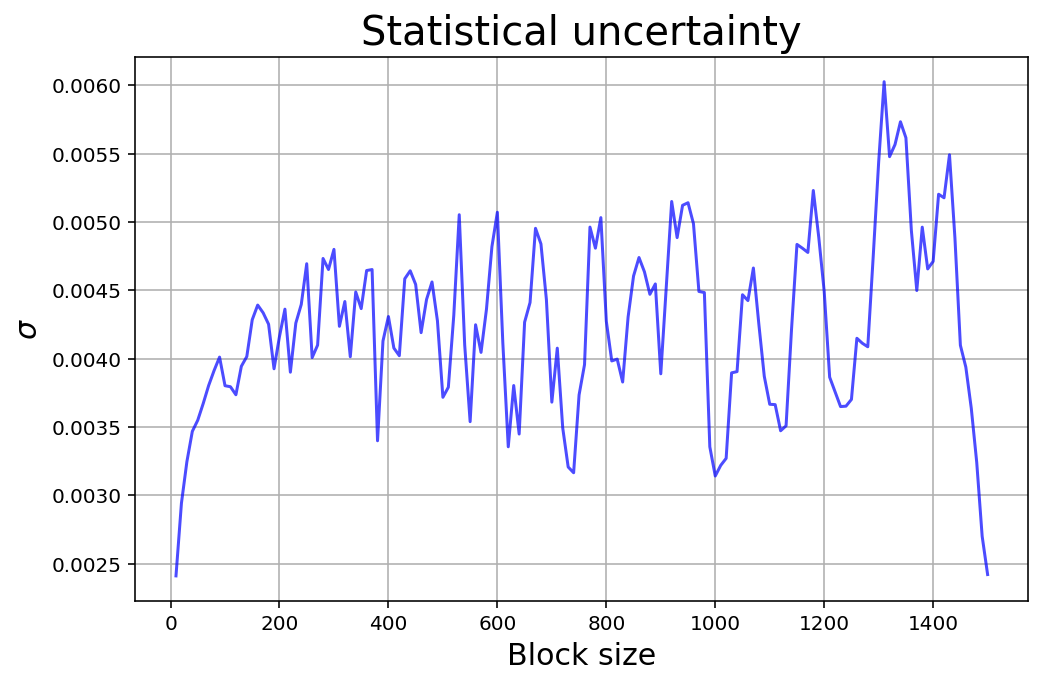

In [4]:
L = np.arange(10,5000,10)
sigma_solid = np.zeros(L.size)
i=0
for l in L:
    sigma_solid[i] = blk_err(eq_solid,l)
    i+=1
    
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(L[0:150],sigma_solid[0:150], color='b', alpha=0.7)
ax.set_title('Statistical uncertainty', size=20)
ax.set_xlabel('Block size', size=15)
ax.set_ylabel(r'$\sigma$', size=15)
ax.grid()

Dai grafici riportati possiamo osservare come per l'equilibrazione della fase solida siano sufficienti un **centianio di passi**. Inoltre, vediamo che oltre questo limite le misure possono essere considerate scorrelate in quanto la funzione di autocorrelazione oscilla attorno a valori prossimi allo $0$. Tuttavia l'errore inizia ad oscillare attorno a un valore stabile per blocchi di dimensioni più grandi di $100$.

Riassumendo sgeliamo per la simulazione i seguenti parametri:
- elementi in un blocco: 200,
- $\Delta r$ = 0.11 (necessario per mantere il rate di accettazione attorno al $50\%$)

### Fase LIQUIDA

#### Equilibrazione, autocorrelazione e incertezza statistica

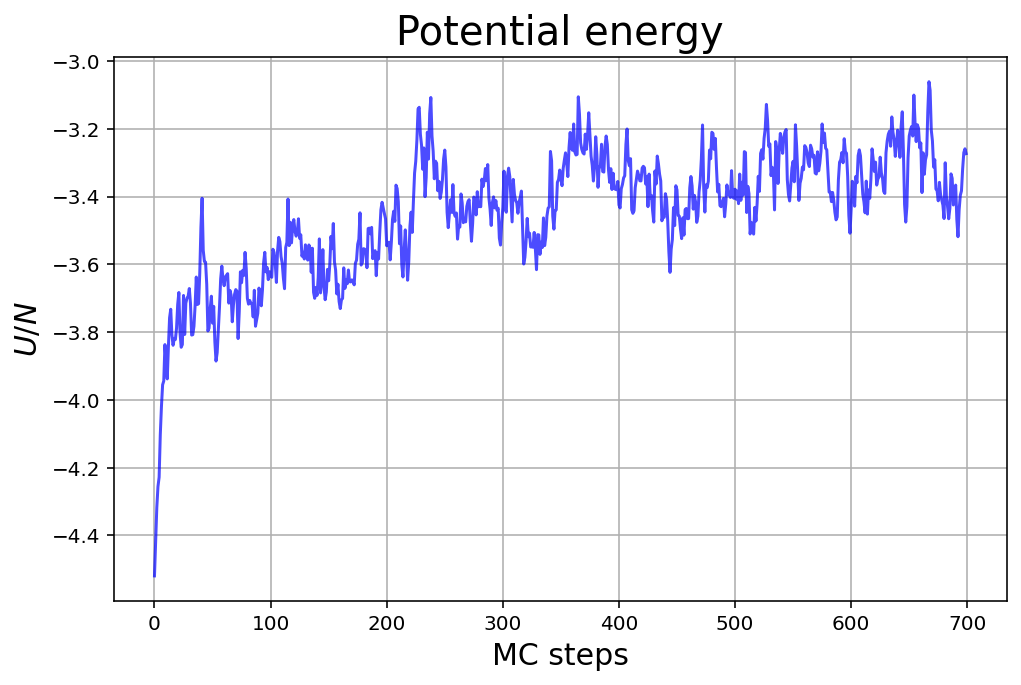

In [5]:
blk, eq_liquid = np.loadtxt('MDNVE_MCNVT/02_Liquid/MC_equilibration.dat', usecols=(0,1), unpack='true')

fig, ax = plt.subplots(figsize=(8,5))
ax.errorbar(blk[0:700], eq_liquid[0:700], color='b', alpha=0.7)
ax.set_title('Potential energy', size=20)
ax.set_xlabel('MC steps', size=15)
ax.set_ylabel('$U/N$', size=15)
ax.grid()

100%|██████████| 5000/5000 [00:01<00:00, 3729.42it/s]


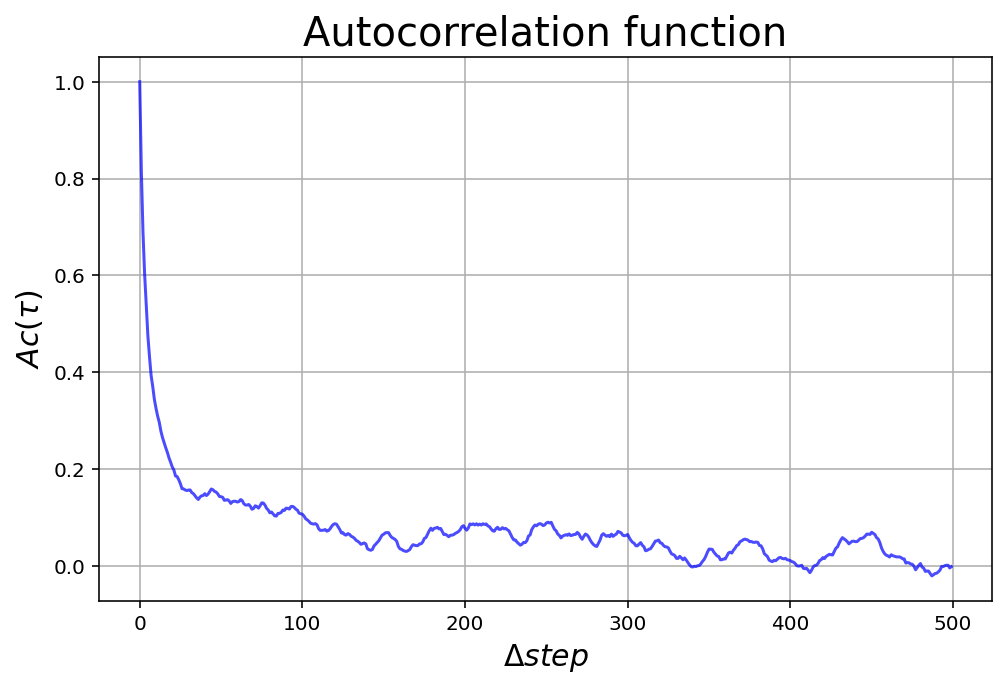

In [6]:
x_liquid = np.loadtxt('MDNVE_MCNVT/02_Liquid/MC_autocorr.dat', usecols=1, unpack='true')
auto_corr = np.zeros(int(x_liquid.size/2))
a = pd.Series(x_liquid)

for i in tqdm(range(int(x_liquid.size/2))):
    y = np.roll(x_liquid,i)
    y = pd.Series(y)
    auto_corr[i] = pd.Series.cov(a,y)/pd.Series.cov(a,a)
    
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(auto_corr[0:500], color='b', alpha=0.7)
ax.set_title('Autocorrelation function', size=20)
ax.set_xlabel(r'$\Delta step$', size=15)
ax.set_ylabel(r'$Ac(\tau)$', size=15)
ax.grid()

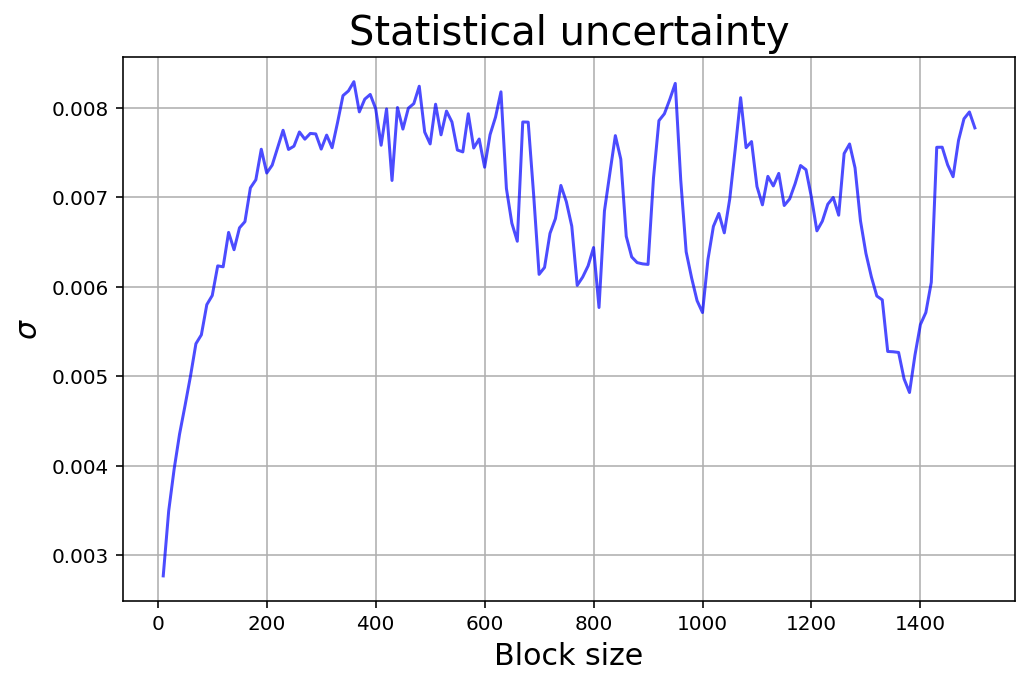

In [7]:
L = np.arange(10,5000,10)
sigma_liquid = np.zeros(L.size)
i=0
for l in L:
    sigma_liquid[i] = blk_err(eq_liquid,l)
    i+=1
    
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(L[0:150],sigma_liquid[0:150], color='b', alpha=0.7)
ax.set_title('Statistical uncertainty', size=20)
ax.set_xlabel('Block size', size=15)
ax.set_ylabel(r'$\sigma$', size=15)
ax.grid()

L'equilibrazione della fase solida avviene in $400$ passi, mentre oltre $200$ passi possiamo già considerare le misure scorrelate tra di loro. Tenendo conto che del numero di passi necessari affinché l'incertezza statistica oscilli attorno a un valore stabile scegliamo i seguenti parametri:
- elementi in un blocco: 400,
- $\Delta r$ = 0.2 (per la regola del $50\%$)

### Fase GASSOSA

#### Equilibrazione, autocorrelazione e incertezza statistica

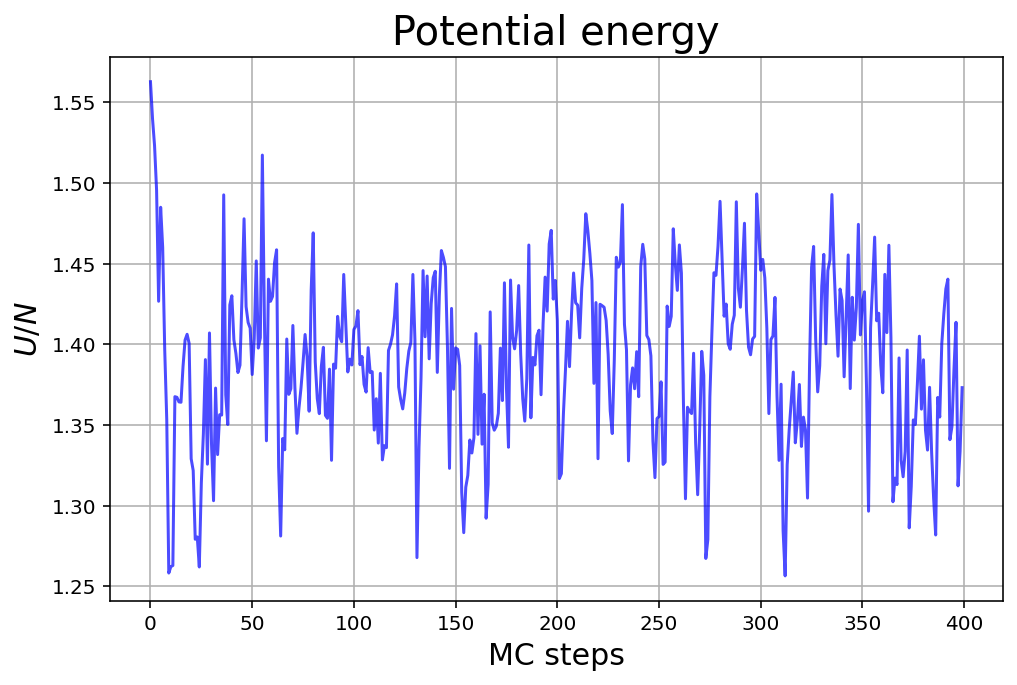

In [8]:
blk, eq_gas = np.loadtxt('MDNVE_MCNVT/03_Gas/MC_equilibration.dat', usecols=(0,1), unpack='true')

fig, ax = plt.subplots(figsize=(8,5))
ax.errorbar(blk[0:400], eq_gas[0:400], color='b', alpha=0.7)
ax.set_title('Potential energy', size=20)
ax.set_xlabel('MC steps', size=15)
ax.set_ylabel('$U/N$', size=15)
ax.grid()

100%|██████████| 5000/5000 [00:01<00:00, 3781.45it/s]


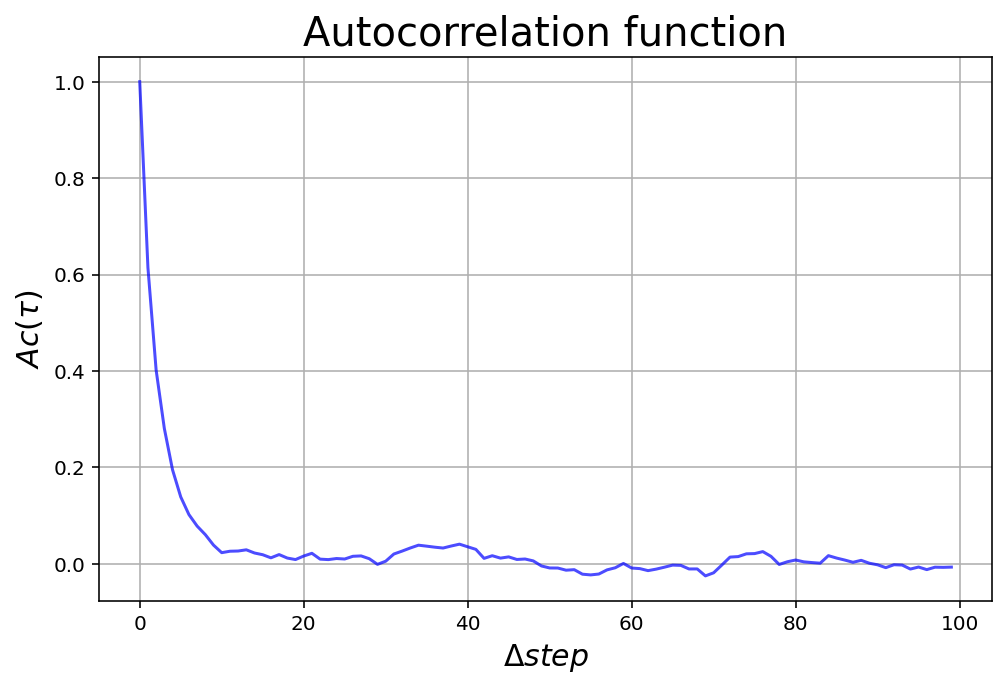

In [9]:
x_gas = np.loadtxt('MDNVE_MCNVT/03_Gas/MC_autocorr.dat', usecols=1, unpack='true')
auto_corr = np.zeros(int(x_gas.size/2))
a = pd.Series(x_gas)

for i in tqdm(range(int(x_gas.size/2))):
    y = np.roll(x_gas,i)
    y = pd.Series(y)
    auto_corr[i] = pd.Series.cov(a,y)/pd.Series.cov(a,a)
    
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(auto_corr[0:100], color='b', alpha=0.7)
ax.set_title('Autocorrelation function', size=20)
ax.set_xlabel(r'$\Delta step$', size=15)
ax.set_ylabel(r'$Ac(\tau)$', size=15)
ax.grid()

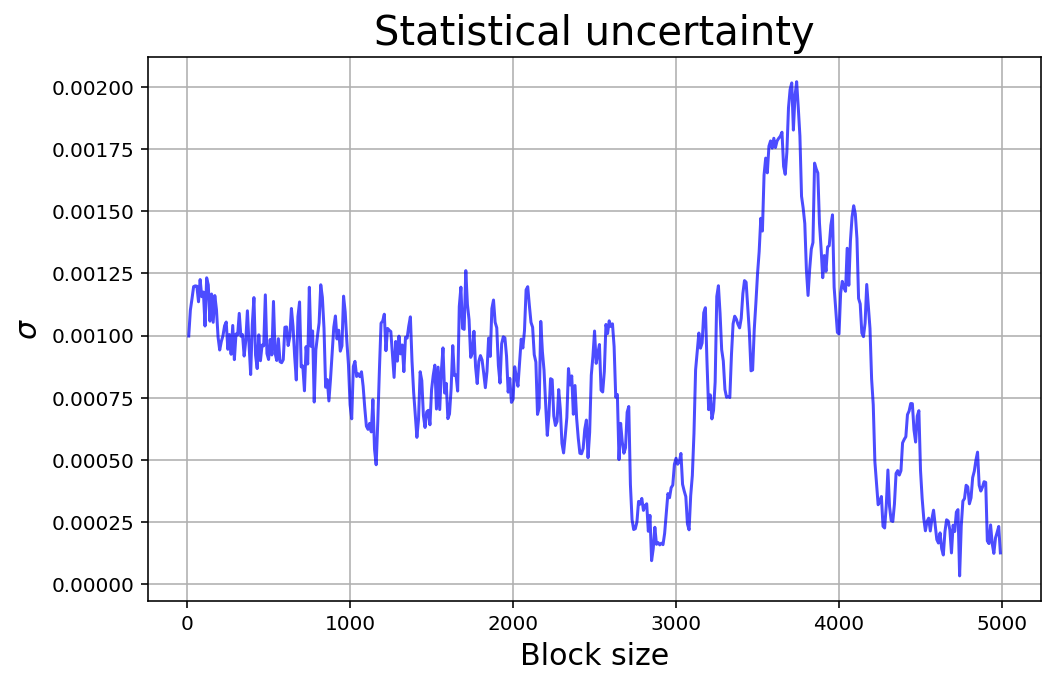

In [10]:
L = np.arange(10,5000,10)
sigma_gas = np.zeros(L.size)
i=0
for l in L:
    sigma_gas[i] = blk_err(eq_gas,l)
    i+=1
    
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(L[0:500],sigma_gas[0:500], color='b', alpha=0.7)
ax.set_title('Statistical uncertainty', size=20)
ax.set_xlabel('Block size', size=15)
ax.set_ylabel(r'$\sigma$', size=15)
ax.grid()

L'equilibrazione della fase gassosa è molto rapida, come anche la decrescita della sua funzione di autocorrelazione. Tuttavia, ciò non si può dire a proposito dell'incertezza statistica che inizia ad oscillare attorno a un valore stabile solo da blocchi di dimensione $1000$ o superiori. per questo motivo sgeliamo per la simulazione i seguenti parametri:
- elementi in un blocco: 1000,
- $\Delta r$ = 6.0 che è poco meno di metà del lato della scatola. In questo caso il rate di accettazione è intorno al $60\%$ ed è difficile ridurlo ulteriormente. Infatti, al contrario del caso precedente, la bassa densità fa sì che siano accettabili molte più configurazioni del sistema. D'altra parte, aumentare di oltre metà lato della scatola il salto compiuto dalle molecole non ha senso in quanto abbiamo imposto condizioni periodiche al contorno.

### Esercizio 07.3

In questo esercizio riportiamo gli andamenti di $g(r)$ per le tre fasi. Il calcolo della funzione di distribuzione radiale consiste nel contare quante particelle si trovano all'interno di una shell di spessore $dr$ posta a distanza $r$ (con un'opportuna normalizzazione). Il range in cui abbiamo calcolato la $g(r)$ è $\left[ 0; L/2\right]$, dove $L$ è il lato della scatola.

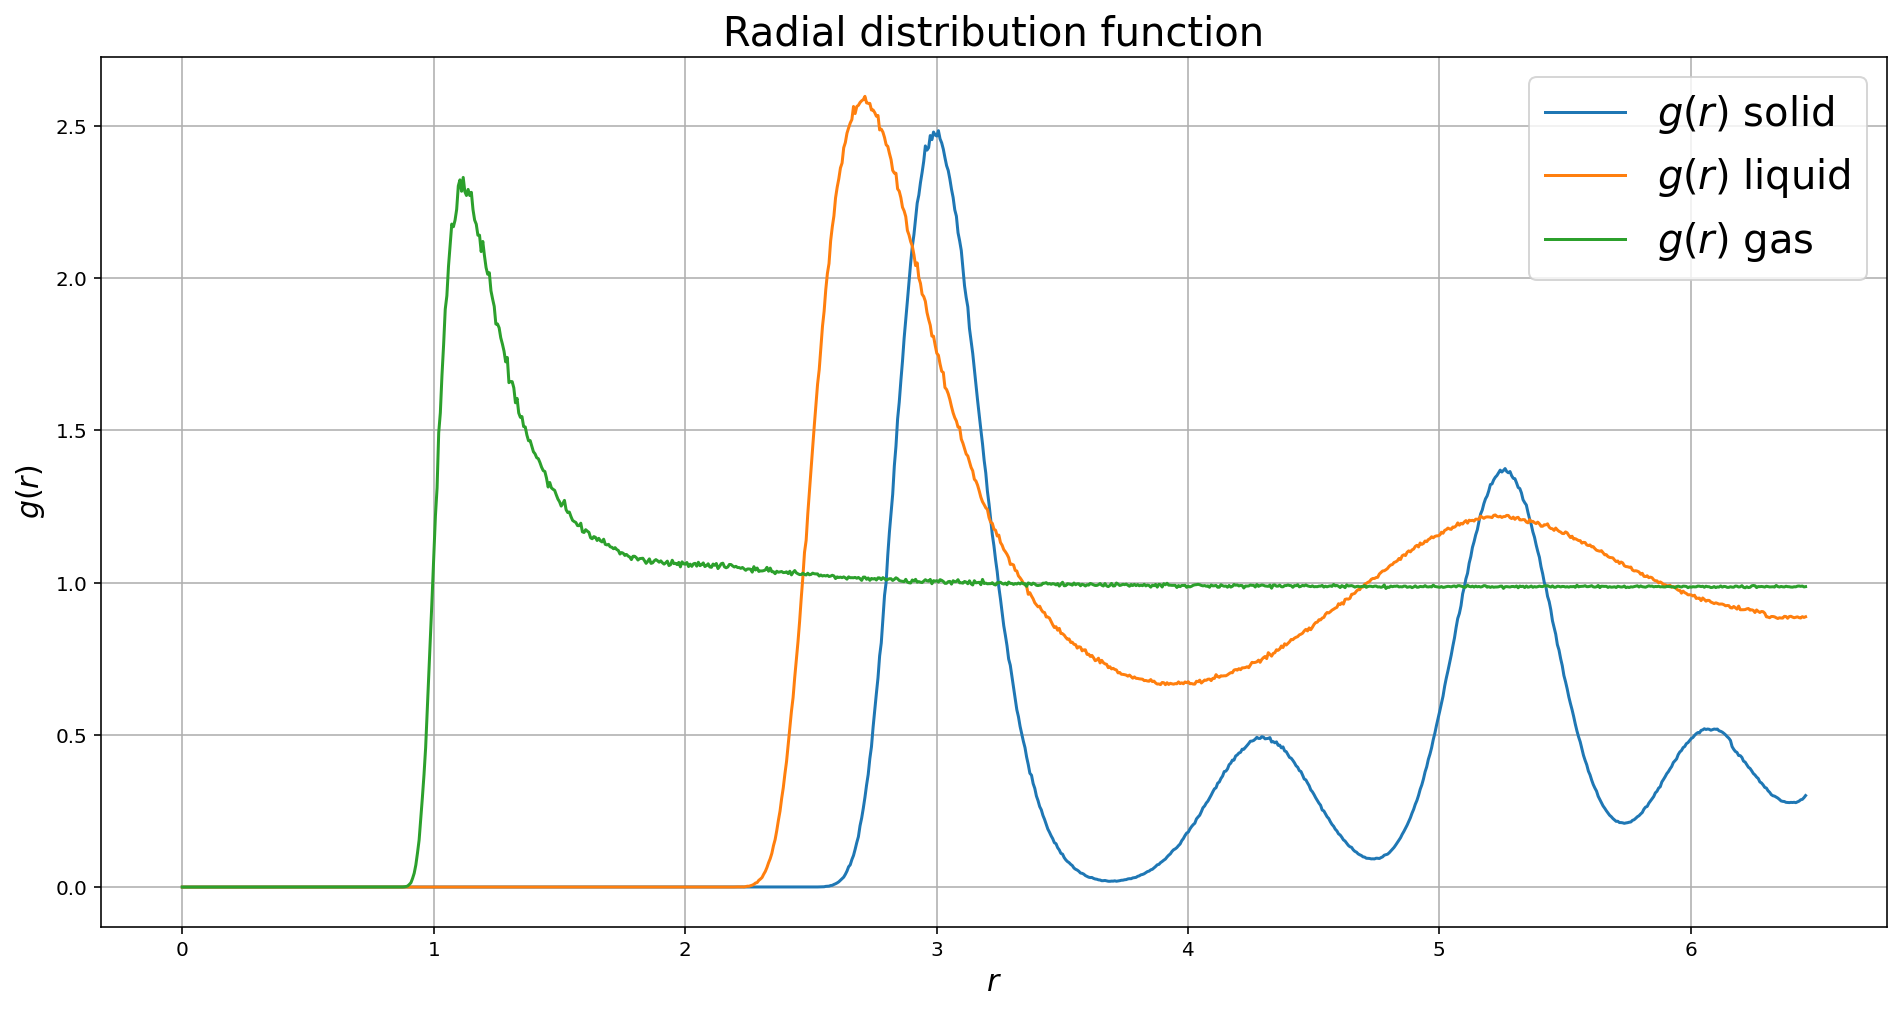

In [25]:
blk, eq_solid = np.loadtxt('MDNVE_MCNVT/01_Solid/MC_output_g.dat', usecols=(0,1), unpack='true')
blk, eq_liquid = np.loadtxt('MDNVE_MCNVT/02_Liquid/MC_output_g.dat', usecols=(0,1), unpack='true')
blk, eq_gas = np.loadtxt('MDNVE_MCNVT/03_Gas/MC_output_g.dat', usecols=(0,1), unpack='true')

gdl = 9995.

fig, ax = plt.subplots(figsize=(16,8))
ax.errorbar(blk, eq_solid/(gdl*2), label='$g(r)$ solid')
ax.errorbar(blk, eq_liquid/(gdl*2), label='$g(r)$ liquid')
ax.errorbar(blk, eq_gas/(gdl*5), label='$g(r)$ gas')
ax.set_title('Radial distribution function', size=20)
ax.set_xlabel('$r$', size=15)
ax.set_ylabel('$g(r)$', size=15)
ax.grid()
ax.legend(fontsize=20)

Osserviamo, dal grafico riportato, che gli andamenti osservati sono quelli comunemente noti in letteratura. Inoltre sottolineiamo come l'approssimazione $g(r)\simeq 1$ mostra essere adeguata per la fase gassosa, mentre per le altre fasi la sua forma è più complessa.

### Esercizio 07.4

Stabilite le condizioni sotto cui fare le simulazioni e fissati i parametri necessari per il data blocking procediamo di seguito presentando i risultati ottenuti dalla simulazioni delle seguenti tre fasi dell'Argon interagente attraverso potenziale di Lennard-Jones:
1. solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cut-off: $r_c = 2.2$)
2. liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cut-off: $r_c = 2.5$)
3. gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off: $r_c = 5.0$)

#### Fase SOLIDA

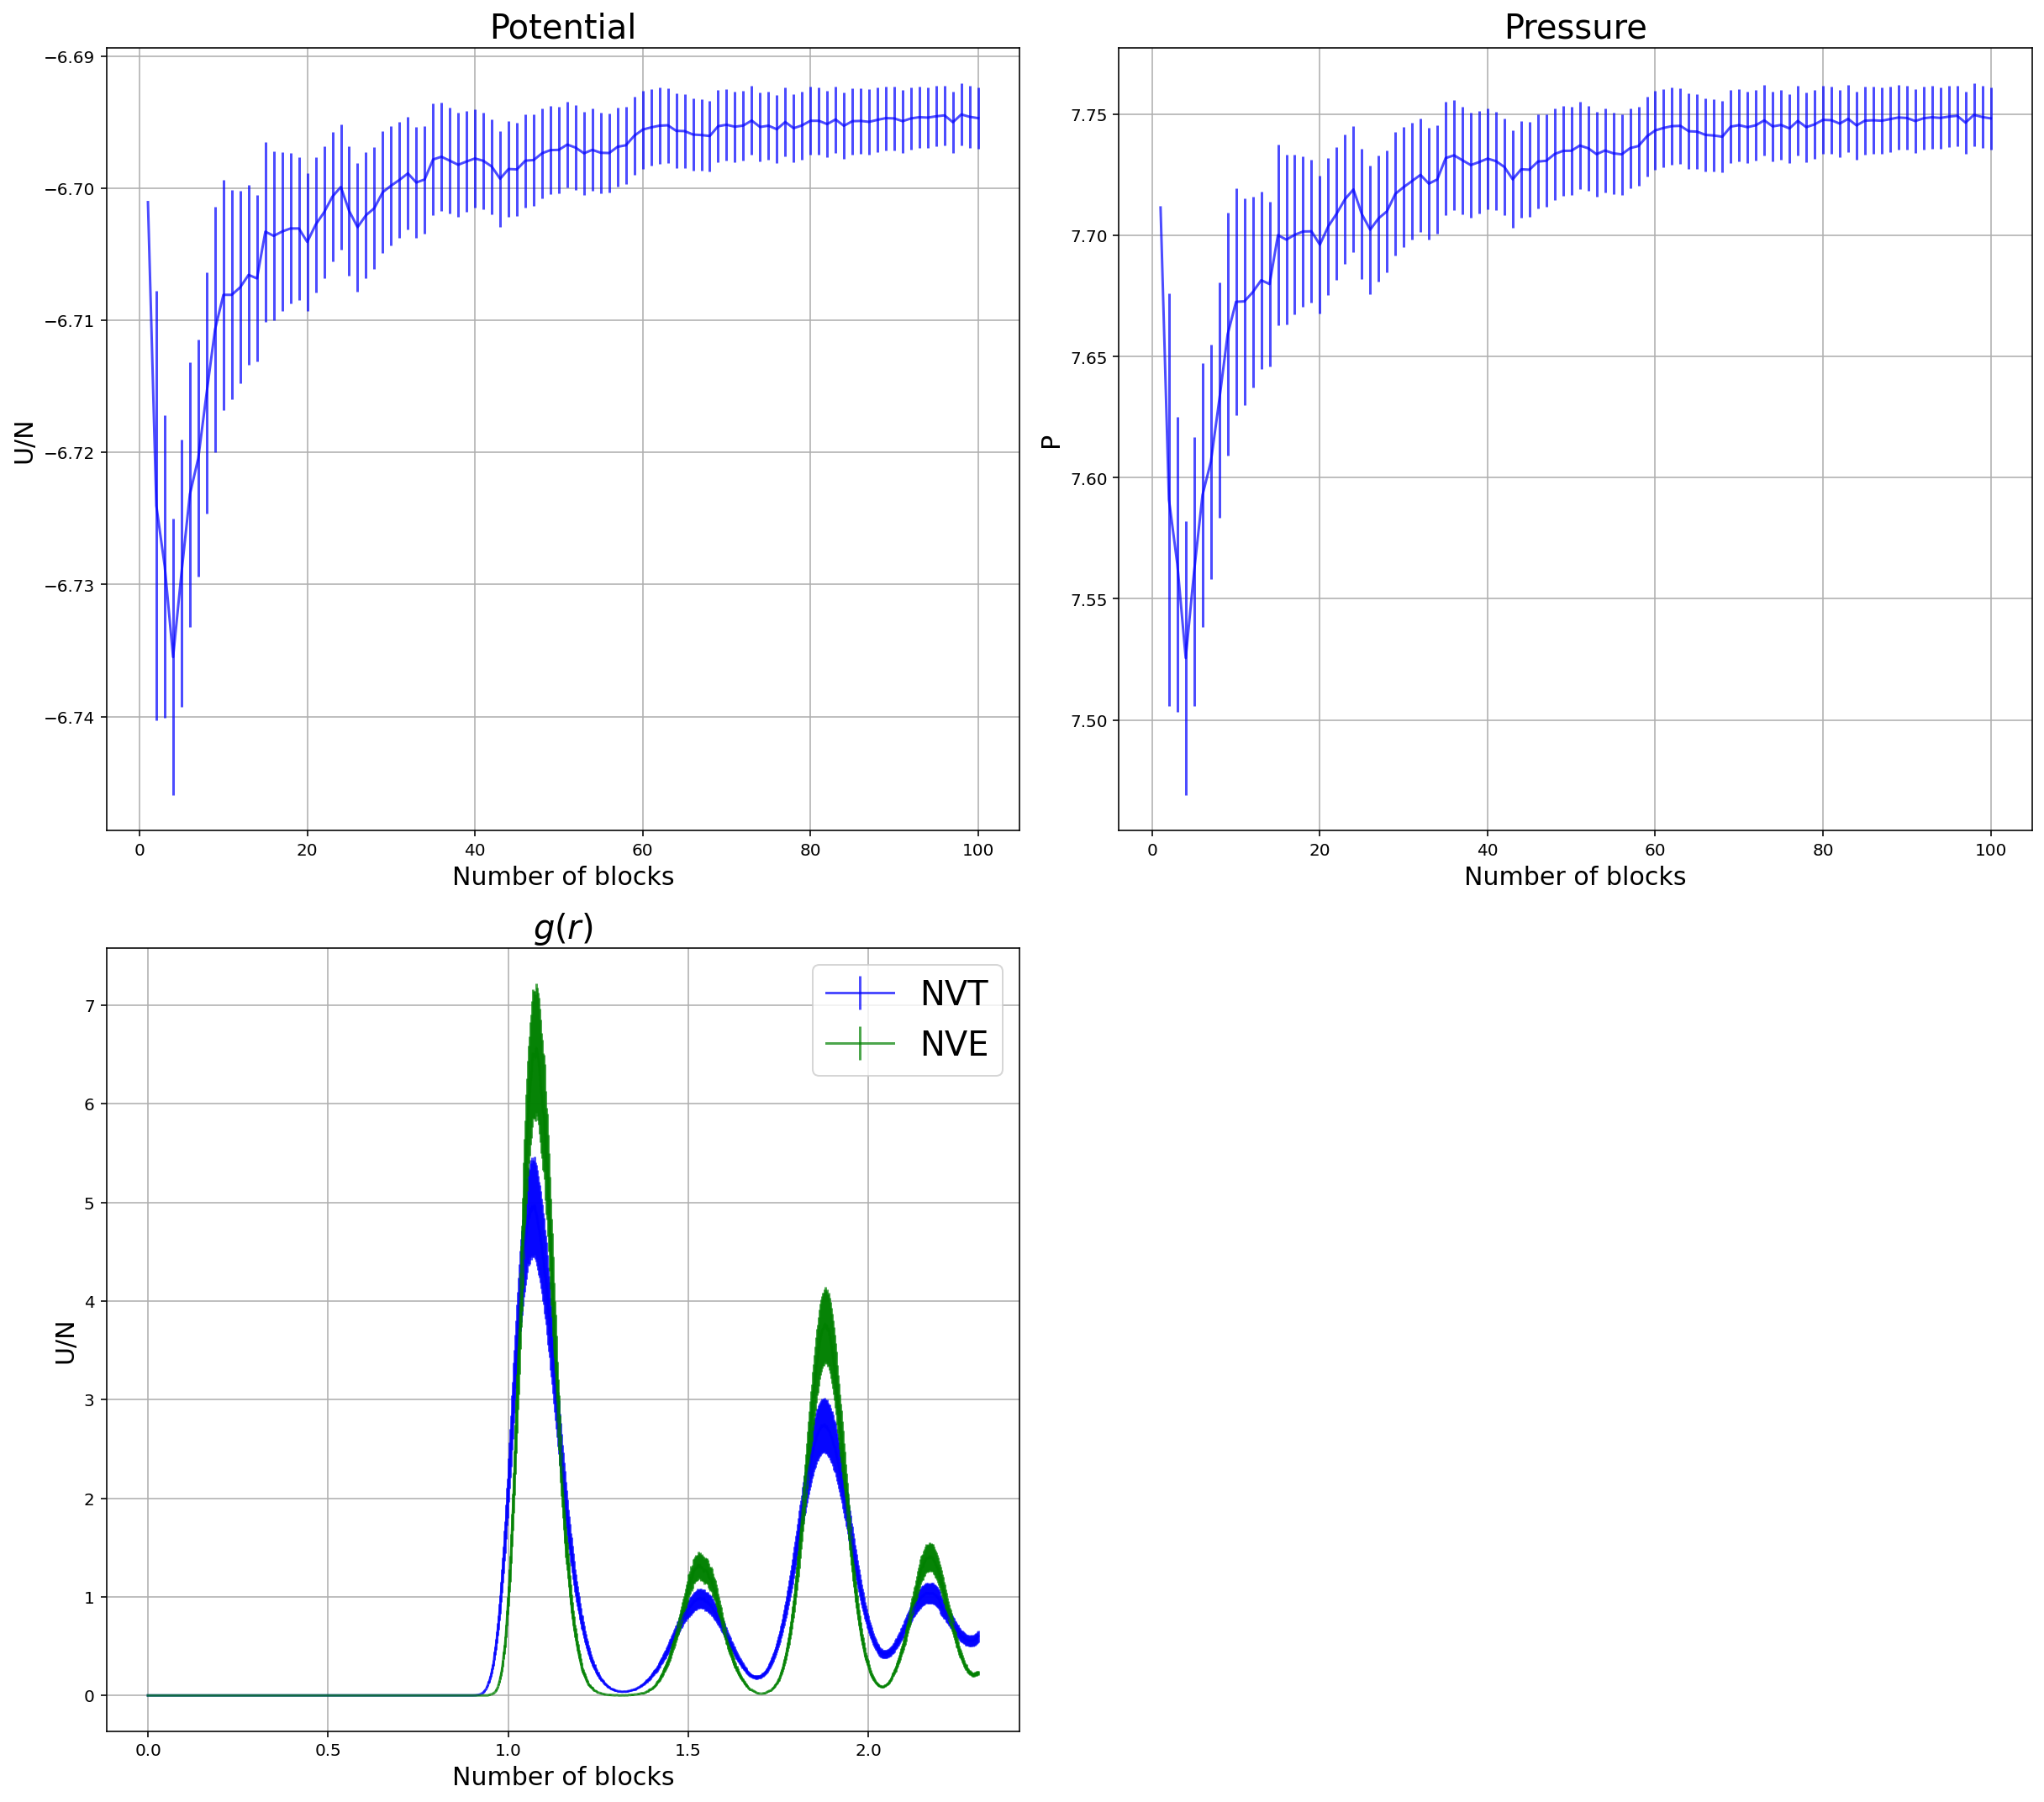

In [12]:
blk = np.loadtxt('MDNVE_MCNVT/01_Solid/MC_output_epot.dat', dtype=int, usecols=0)

Potential, sigma_pot = np.loadtxt('MDNVE_MCNVT/01_Solid/MC_output_epot.dat', dtype=float, usecols=(2,3), unpack='true')
Pressure, sigma_p = np.loadtxt('MDNVE_MCNVT/01_Solid/MC_output_p.dat', dtype=float, usecols=(2,3), unpack='true')
r, g_MC, sigma_g_MC = np.loadtxt('MDNVE_MCNVT/01_Solid/MC_output_g.dat', dtype=float, usecols=(0,1,2), unpack='true')
g_MD, sigma_g_MD = np.loadtxt('MDNVE_MCNVT/01_Solid/NVE_output_g.dat', dtype=float, usecols=(1,2), unpack='true')

fig, ax = plt.subplots(2,2, figsize=(17,15))
ax[0][0].errorbar(blk, Potential, yerr=sigma_pot, color='b', alpha=0.7)
ax[0][0].set_title('Potential', size=20)
ax[0][0].set_xlabel('Number of blocks',size=15)
ax[0][0].set_ylabel('U/N',size=15)
ax[0][0].grid()
ax[0][1].errorbar(blk, Pressure, yerr=sigma_p, color='b', alpha=0.7)
ax[0][1].set_xlabel('Number of blocks',size=15)
ax[0][1].set_title('Pressure', size=20)
ax[0][1].set_ylabel('P',size=15)
ax[0][1].grid()
ax[1][0].errorbar(r, g_MC/9995, yerr=sigma_g_MC/9995, color='b', alpha=0.7, label='NVT')
ax[1][0].set_title('$g(r)$', size=20)
ax[1][0].set_xlabel('Number of blocks',size=15)
ax[1][0].set_ylabel('U/N',size=15)
ax[1][0].grid()
ax[1][0].errorbar(r, g_MD/9995, yerr=sigma_g_MD/9995, color='g', alpha=0.7, label='NVE')
ax[1][0].legend(fontsize=20)
fig.delaxes(ax[1][1])
fig.tight_layout()

I valori di energia potenziale e pressione sono dell'ordine di grandezza di quanto era stato osservato tramite la dinamica molecolare. Osservando la $g(r)$, sebbene si vedano discrepanze tra i due metodi di simulazione, vediamo un andamento molto simile tra i due casi. Lo spessore della linea è dovuto alla densità di dati calcolati e alle barre d'errore.

#### Fase LIQUIDA

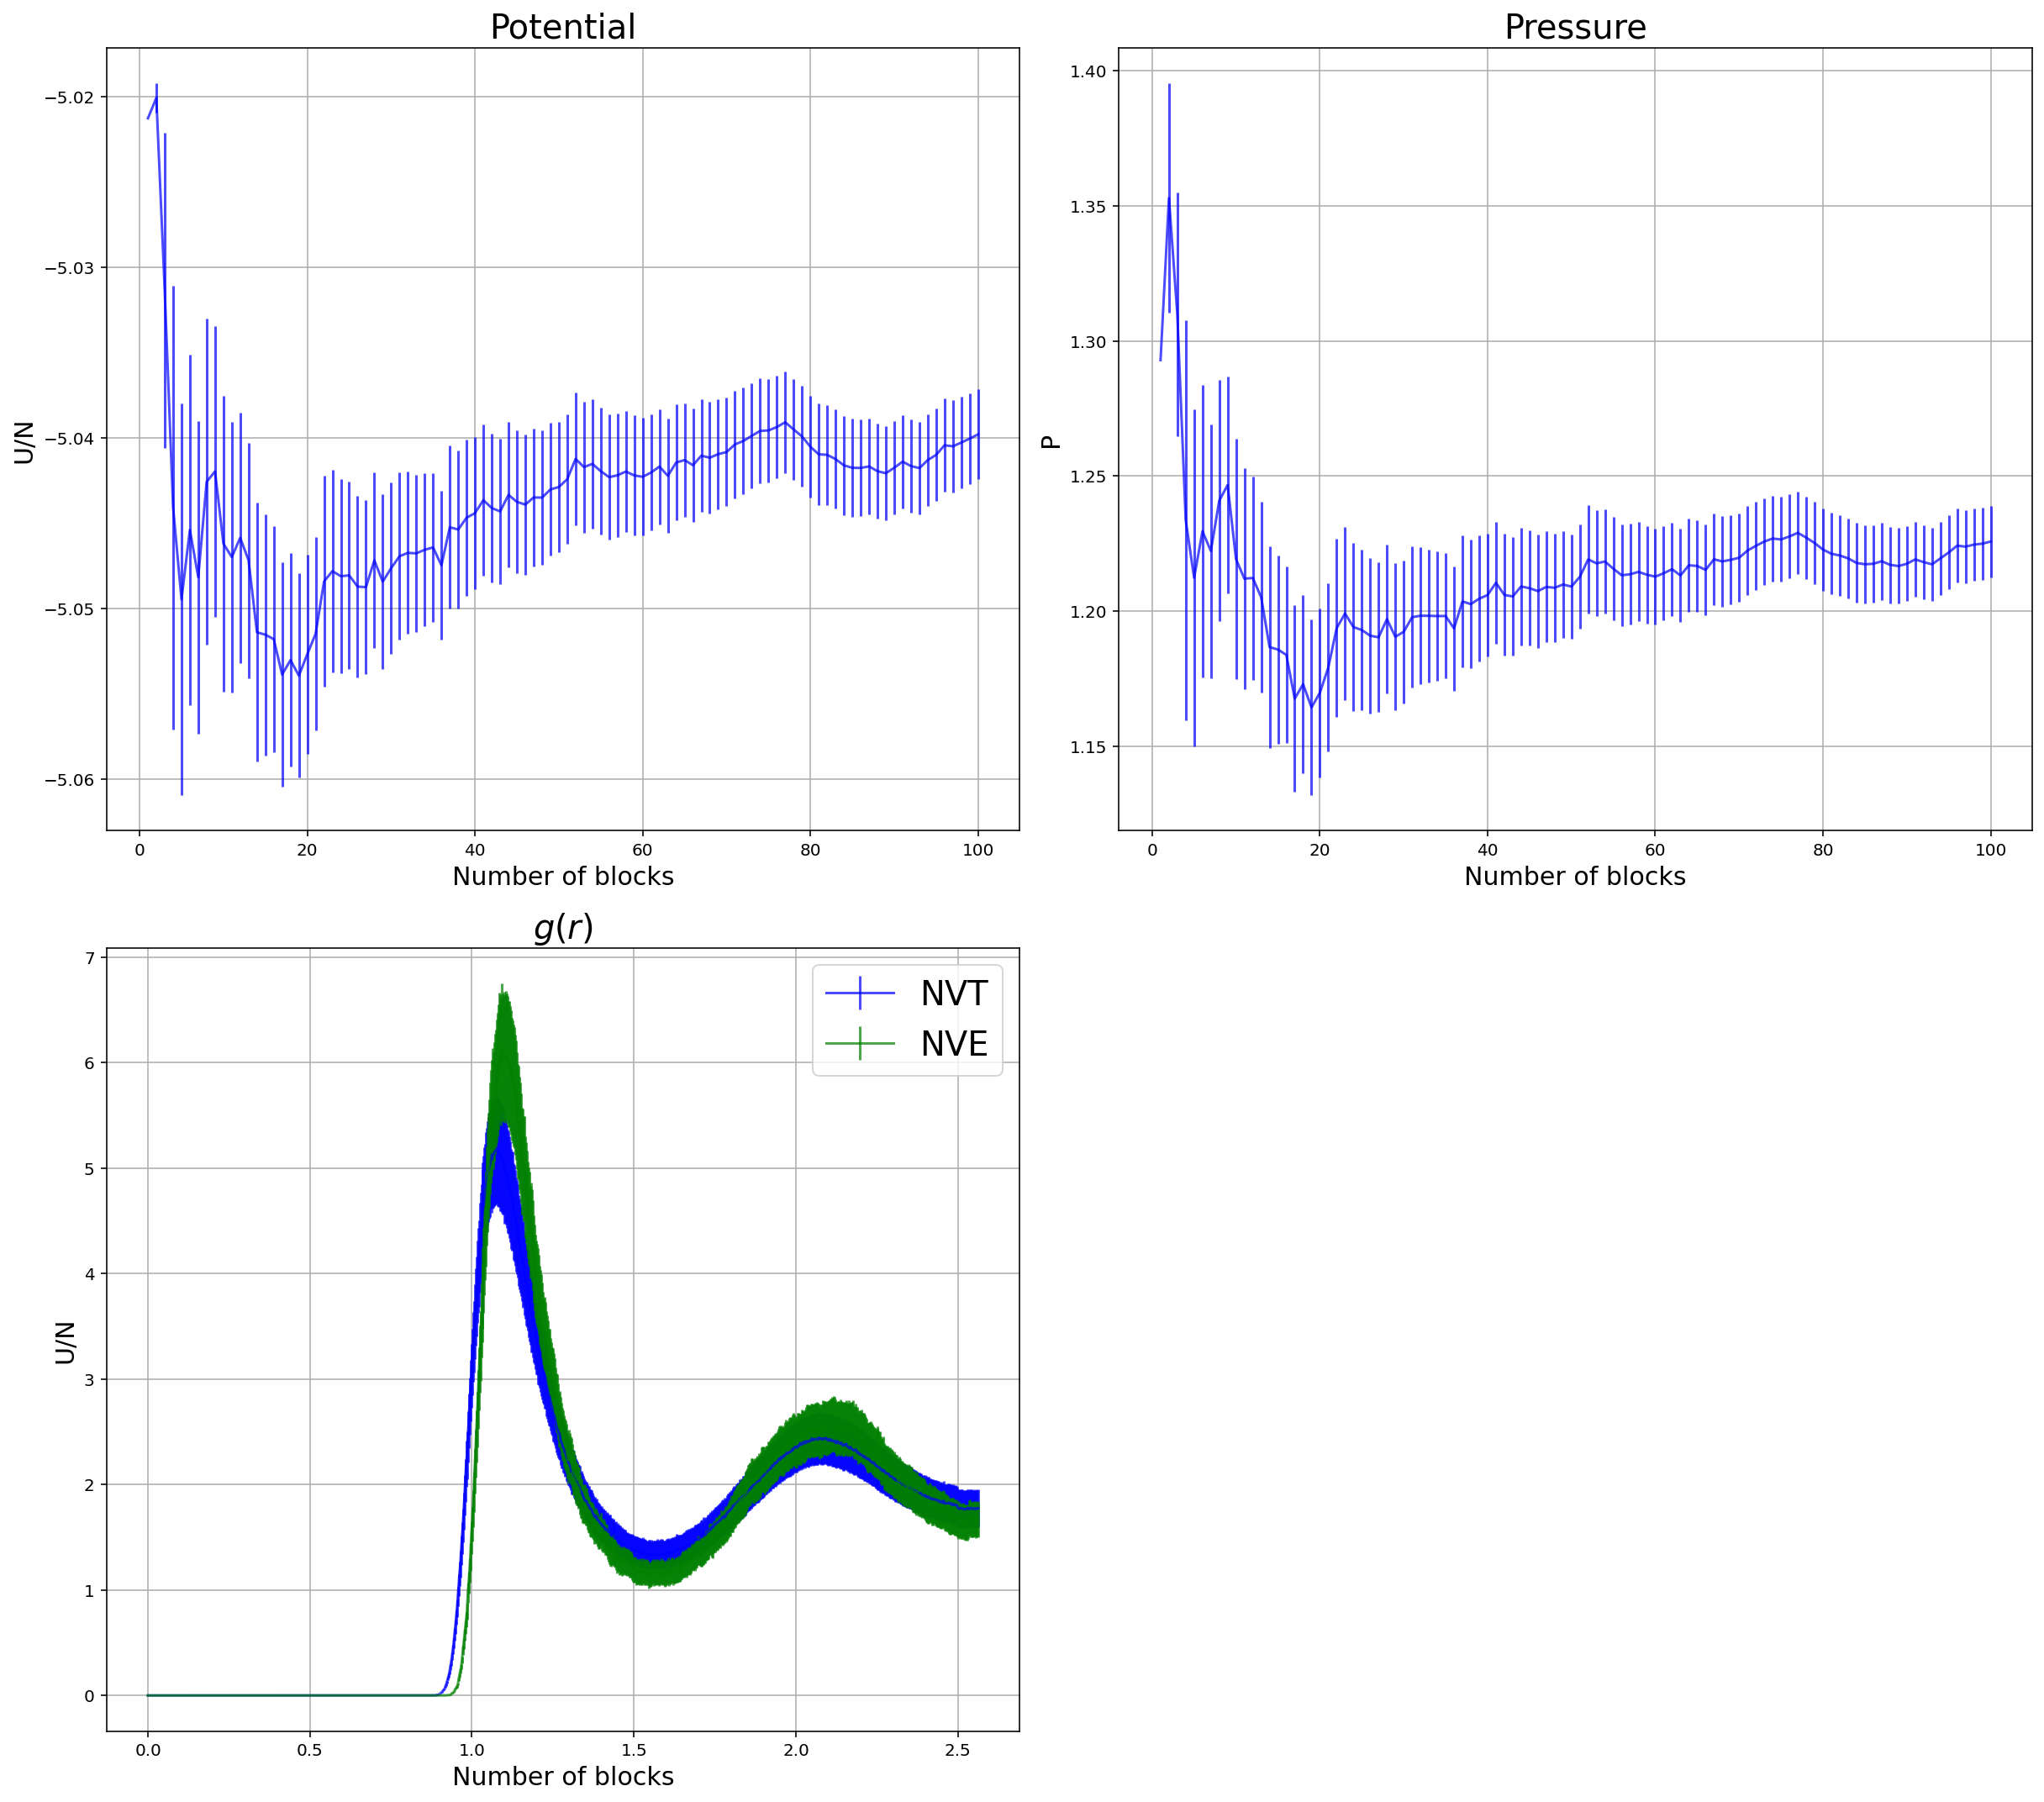

In [13]:
blk = np.loadtxt('MDNVE_MCNVT/02_Liquid/MC_output_epot.dat', dtype=int, usecols=0)

Potential, sigma_pot = np.loadtxt('MDNVE_MCNVT/02_Liquid/MC_output_epot.dat', dtype=float, usecols=(2,3), unpack='true')
Pressure, sigma_p = np.loadtxt('MDNVE_MCNVT/02_Liquid/MC_output_p.dat', dtype=float, usecols=(2,3), unpack='true')
r, g_MC, sigma_g_MC = np.loadtxt('MDNVE_MCNVT/02_Liquid/MC_output_g.dat', dtype=float, usecols=(0,1,2), unpack='true')
g_MD, sigma_g_MD = np.loadtxt('MDNVE_MCNVT/02_Liquid/NVE_output_g.dat', dtype=float, usecols=(1,2), unpack='true')

fig, ax = plt.subplots(2,2, figsize=(17,15))
ax[0][0].errorbar(blk, Potential, yerr=sigma_pot, color='b', alpha=0.7)
ax[0][0].set_title('Potential', size=20)
ax[0][0].set_xlabel('Number of blocks',size=15)
ax[0][0].set_ylabel('U/N',size=15)
ax[0][0].grid()
ax[0][1].errorbar(blk, Pressure, yerr=sigma_p, color='b', alpha=0.7)
ax[0][1].set_xlabel('Number of blocks',size=15)
ax[0][1].set_title('Pressure', size=20)
ax[0][1].set_ylabel('P',size=15)
ax[0][1].grid()
ax[1][0].errorbar(r, g_MC/9995, yerr=sigma_g_MC/9995, color='b', alpha=0.7, label='NVT')
ax[1][0].set_title('$g(r)$', size=20)
ax[1][0].set_xlabel('Number of blocks',size=15)
ax[1][0].set_ylabel('U/N',size=15)
ax[1][0].grid()
ax[1][0].errorbar(r, g_MD/9995, yerr=sigma_g_MD/9995, color='g', alpha=0.7, label='NVE')
ax[1][0].legend(fontsize=20)
fig.delaxes(ax[1][1])
fig.tight_layout()

Come nel caso slido, anche ora i valori di energia potenziale e pressione sono dello stesso ordine di grandezza trovato con la dinamica molecolare. Inoltre possiamo osservare che si riduce la discrepanza tra le due $g(r)$. Come precedentemente, lo spessore della linea è dovuto alla densità di punti rappresentati e dalle rispettive barre d'errore.

#### Fase GASSOSA

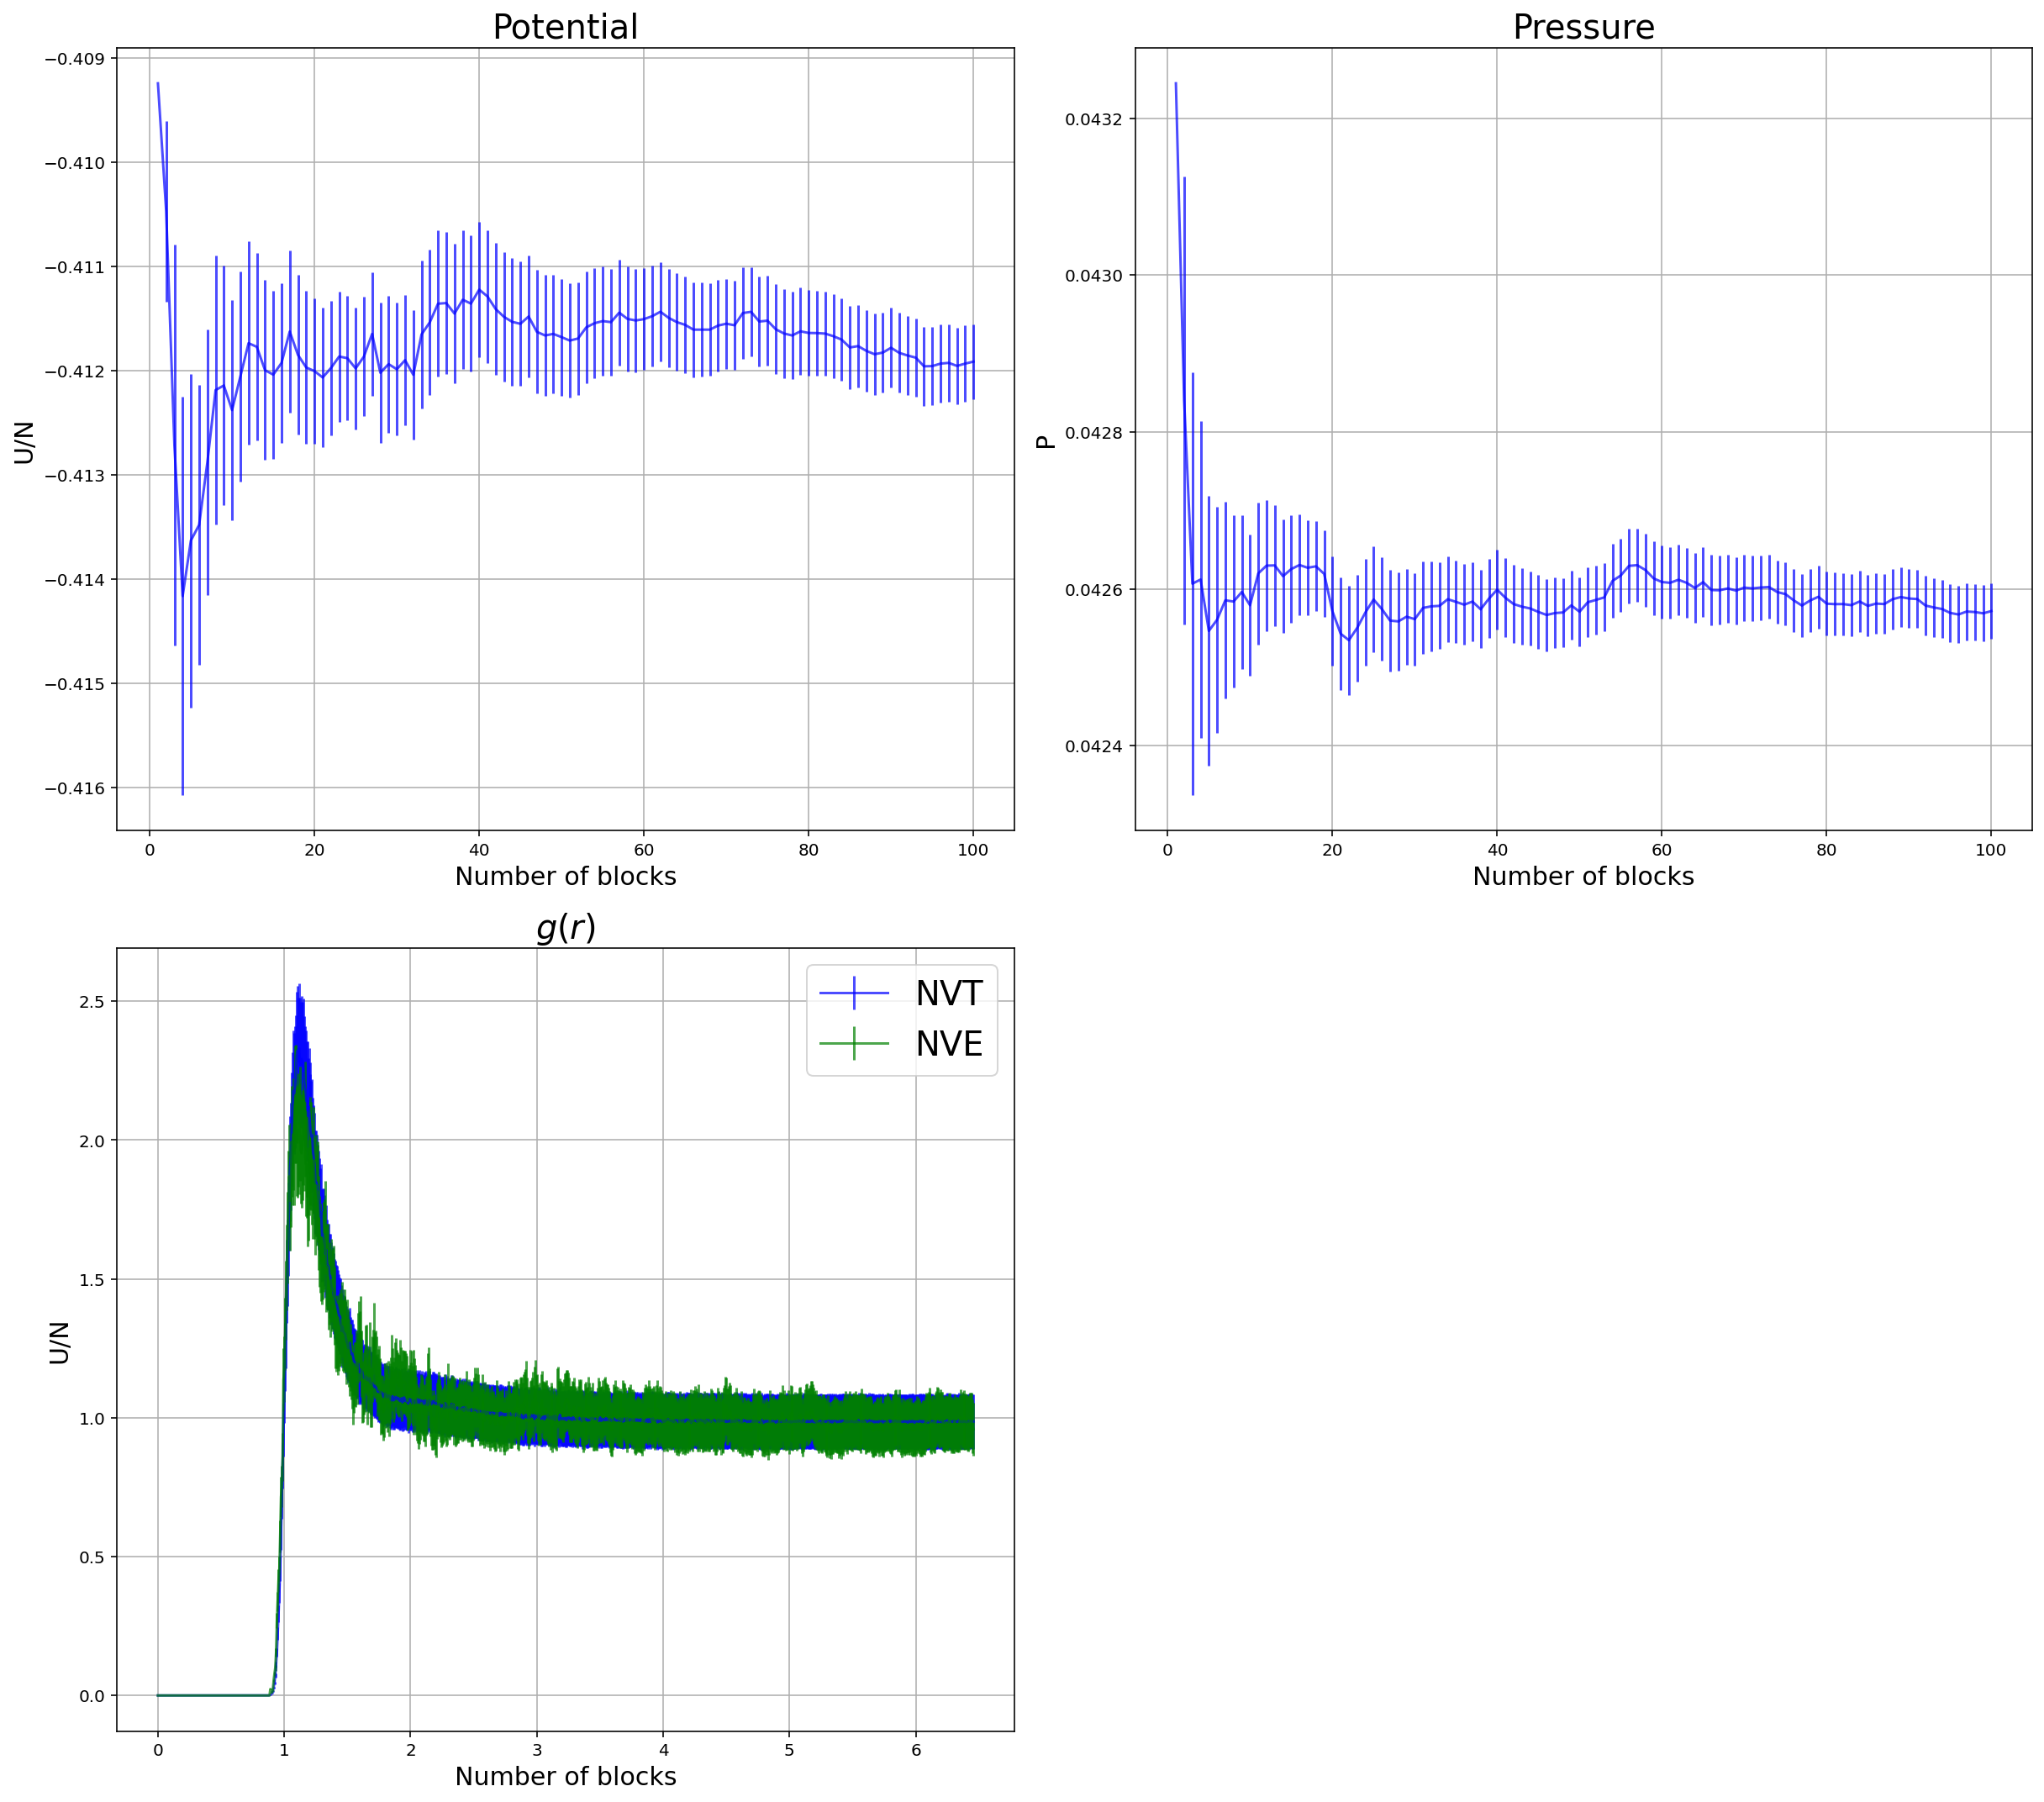

In [27]:
blk = np.loadtxt('MDNVE_MCNVT/03_Gas/MC_output_epot.dat', dtype=int, usecols=0)

Potential, sigma_pot = np.loadtxt('MDNVE_MCNVT/03_Gas/MC_output_epot.dat', dtype=float, usecols=(2,3), unpack='true')
Pressure, sigma_p = np.loadtxt('MDNVE_MCNVT/03_Gas/MC_output_p.dat', dtype=float, usecols=(2,3), unpack='true')
r, g_MC, sigma_g_MC = np.loadtxt('MDNVE_MCNVT/03_Gas/MC_output_g.dat', dtype=float, usecols=(0,1,2), unpack='true')
g_MD, sigma_g_MD = np.loadtxt('MDNVE_MCNVT/03_Gas/NVE_output_g.dat', dtype=float, usecols=(1,2), unpack='true')

fig, ax = plt.subplots(2,2, figsize=(17,15))
ax[0][0].errorbar(blk, Potential, yerr=sigma_pot, color='b', alpha=0.7)
ax[0][0].set_title('Potential', size=20)
ax[0][0].set_xlabel('Number of blocks',size=15)
ax[0][0].set_ylabel('U/N',size=15)
ax[0][0].grid()
ax[0][1].errorbar(blk, Pressure, yerr=sigma_p, color='b', alpha=0.7)
ax[0][1].set_xlabel('Number of blocks',size=15)
ax[0][1].set_title('Pressure', size=20)
ax[0][1].set_ylabel('P',size=15)
ax[0][1].grid()
ax[1][0].errorbar(r, g_MC/(gdl*5), yerr=sigma_g_MC/(gdl*5), color='b', alpha=0.7, label='NVT')
ax[1][0].set_title('$g(r)$', size=20)
ax[1][0].set_xlabel('Number of blocks',size=15)
ax[1][0].set_ylabel('U/N',size=15)
ax[1][0].grid()
ax[1][0].errorbar(r, g_MD/gdl, yerr=sigma_g_MD/9995, color='g', alpha=0.7, label='NVE')
ax[1][0].legend(fontsize=20)
fig.delaxes(ax[1][1])
fig.tight_layout()

Il caso di fase gassosa è quello dove i risultati sono migliori: infatti si è ridotta la discrepanza con quanto osservato nella quarta esercitazione e le $g(r)$ risultano essere compatibili. Tutto questo può essere spiegato se si osserva che nel caso del gas le approssimazioni fatte sono meno significative che negli altri due casi dove l'interazione gioca un ruolo maggiore.